# Testing a general data reader for AQUA 
## (working on Levante for now)

The idea of this AQUA reader draft is to provide a first common access point to data in order to quickly develop diagnostics. For now access is through intake catalogues of NextGEMS data, but the idea is to extend this to FDB access and other datasources in the future.

It includes also regridding functionality. The idea of the regridder (which uses sparse matrix multiplication) is to generate first the weights for the interpolation (an operation which needs to be done only once) and then to use them for each regridding operation.

Further, the reader includes a simple 'data fixer', that is the capability to edit the metadata of the input datasets fixing variable or coordinate names and performing unit conversions. 

For all this to work you will need the external [smmregrid](https://github.com/jhardenberg/smmregrid) module.

In [1]:
from aqua import Reader, catalogue

Optional: open a cluster to parallelize dask

In [2]:
# from dask.distributed import LocalCluster, Client, progress
# cluster = LocalCluster(ip="0.0.0.0", threads_per_worker=2, n_workers=16)
# client = Client(cluster)
# cluster

In [23]:
# from dask.distributed import LocalCluster, Client, progress
# processes = False
# nworker = 32
# ncpu = 32
# threads = ncpu // nworker
# print(f"Number of CPUs: {ncpu}, number of threads: {threads}, number of workers: {nworker}, processes: {processes}")
# client = Client(processes=processes,
#  threads_per_worker=threads,
#  n_workers=nworker,
#  memory_limit='64GB'
#  )

Number of CPUs: 32, number of threads: 1, number of workers: 32, processes: False


First let's see what is available (this function also returns the intake catalogue, that's why we use a semicolon)

In [2]:
catalogue();

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
	- interpolated_sp_ci	
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	

FESOM	tco3999-ng5	2.5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- np	nearest-neighbor interpolation to lat-lon grid
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	original 2d output
	- original_3d	original 3d output
FESOM	tco2559-ng5	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	orig

The `configdir` argument can be passed to provide the path where the configuration and catalog files are, both to the catalogue and to the regridder. It can be useful if you are not running in the AQUA folder.

In [3]:
catalogue(configdir='/home/b/b382075/AQUA/config');

IFS	tco3999-ng5	2.8km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
	- interpolated_sp_ci	
IFS	tco2559-ng5	4km experiment, coupled with FESOM
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	
	- interpolated_global	
	- interpolated_np	
	- interpolated_sp	
IFS	tco1279-orca025	9km baseline, coupled to NEMO, deep conv ON
	- ICMGG_atm2d	
	- ICMU_atm2d	
	- ICMU_atm3d	

FESOM	tco3999-ng5	2.5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- np	nearest-neighbor interpolation to lat-lon grid
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	original 2d output
	- original_3d	original 3d output
FESOM	tco2559-ng5	5km experiment, coupuled with IFS
	- elem_grid	
	- node_grid	
	- interpolated_global2d	
	- interpolated_global_TS	
	- interpolated_global_UV	
	- interpolated_np	
	- interpolated_sp	
	- original_2d	orig

## Example 1: IFS

Now let's load some IFS data. We first instantiate a `Reader` object specifying the type of data which we want to read from the catalogue. Then the actual data are read with the `retrieve` method. The `fix=False` for now prevents it from attempting to add unit fixes and other fixes. It also accept the `configdir` argument.

In [2]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d")
data = reader.retrieve(fix=False)

These are raw IFS data on the original grid

In [3]:
data

<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

### Regridding
Let's try again, this time specifying that we want to regrid to a specific regular grid (0.2 deg in this case)

In [5]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", regrid="r010")
data = reader.retrieve(fix=False)

Weights file not found: /work/bb1153/b382075/nextgems/weights/weights_IFS_tco2559-ng5_ICMGG_atm2d_ycon_r010_l2d.nc
Attempting to generate it ...
Source grid:  /work/bm1235/a270046/cycle2-sync/tcogrids/4km/tcogrids/tco2559_grid.nc
Success!


again, by deafault, the data are still on the raw original grid. Let's look at temperature

In [7]:
data["2t"][1,:]

<xarray.DataArray '2t' (value: 26306560)>
dask.array<getitem, shape=(26306560,), dtype=float64, chunksize=(26306560,), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    time     datetime64[ns] 2020-01-20T01:00:00
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    167
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       2 metre temperature
    cfVarName:                  t2m
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

... but we can now ask to regrid it (or part of it) to the destination grid which we chose when we instantiated the reader.

In [8]:
tasr = reader.regrid(data["2t"][0:3,:])

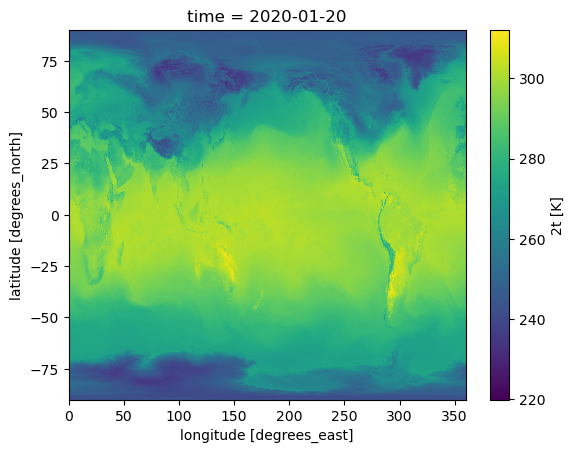

In [9]:
tasr[0,:,:].plot()

### Both regrid and time averaging
A further possibility also includes performing some time averaging with the `average()` method via the `freq` argument. For convenience, time averaging is done before of the regridder but can be used at the same time. As before, the data are provided on original grid and time, so that anything is done at the initial stage.

NB: Please note that this is terribly costly when working with big files and you might want to use dask.

In [10]:
reader = Reader(model="IFS", exp="tco2559-ng5", source="ICMGG_atm2d", freq='day', regrid="r100")
data = reader.retrieve(fix=False)
data

Weights file not found: /work/bb1153/b382075/nextgems/weights/weights_IFS_tco2559-ng5_ICMGG_atm2d_ycon_r100_l2d.nc
Attempting to generate it ...
Source grid:  /work/bm1235/a270046/cycle2-sync/tcogrids/4km/tcogrids/tco2559_grid.nc
Success!


<xarray.Dataset>
Dimensions:  (time: 8329, value: 26306560, level: 5)
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * level    (level) int64 1 2 3 4 5
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Data variables: (12/81)
    100si    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100u     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    100v     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10u      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    10v      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    2d       (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    ...       ...
    uvb      (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vike     (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipie    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vipile   (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    vithe    (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
    z        (time, value) float64 dask.array<chunksize=(1, 26306560), meta=np.ndarray>
Attributes:
    edition:            1
    centre:             ecmf
    centreDescription:  European Centre for Medium-Range Weather Forecasts
    subCentre:          0
    history:            🪄🧙‍♂️🔮 magic dataset assembly provided by gribscan.IF...

Then we can call the averaging function on only the precipitation...

In [11]:
daily = reader.average(data['tp'])
daily

<xarray.DataArray 'tp' (time: 348, value: 26306560)>
dask.array<stack, shape=(348, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/15)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

Then we can apply the regridder to only the third frame...

In [12]:
daily.time

<xarray.DataArray 'time' (time: 348)>
array(['2020-01-20T00:00:00.000000000', '2020-01-21T00:00:00.000000000',
       '2020-01-22T00:00:00.000000000', ..., '2020-12-30T00:00:00.000000000',
       '2020-12-31T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 2020-01-21 ... 2021-01-01

In [13]:
prs = reader.regrid(daily[2,:])
prs

<xarray.DataArray 'tp' (lat: 180, lon: 360)>
dask.array<reshape, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
    time     datetime64[ns] 2020-01-22
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes: (12/15)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    name:                       Total precipitation
    cfVarName:                  tp
    missingValue:               9999
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid

And we call the plot. This might takes a bit of time, since the files need to be loaded. Dask should be reasonably efficient calling only the frames that we need to create the time averaging. 

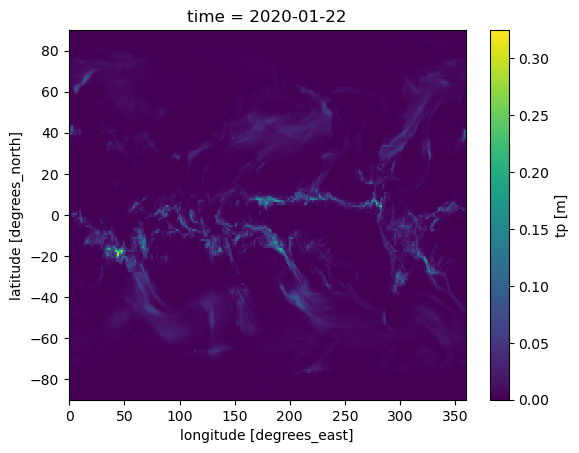

In [14]:
prs.plot()

Notice: You could ask to regrid data by specifying the argument `average=True` and `regrid=True` to the retrieve method when reading the data, but please be warned that without a selection on dates this will take longer. It is usually more efficient to first load the data, select, average and then regrid. The option `regrid=True` for the reader will make sense probably for streamed data, if you know that you will want to regrid all of the input xarray anyway. The regridding is applied to a dask dataarray, so execution is delayed and one can select variables and periods of interest later, but still, it takes longer by asking to regrid everything at this stage. To be tested further.

### Coordinate, variable name and unit fixer

Now let's try again dropping the `fix=false` flag:

In [ ]:
data = reader.retrieve()

tp: corrected multiplying by density of water 1000 kg m-3
tp: corrected dividing by accumulation time 10800 s


The resulting data are now adjusted using the instructions in the `config/fixes.yaml` file. For now, for IFS data `2t` is renamed to `tas` and `tp` is converted to `pr`. Units are converted too and cumulated IFS fluxes are converted to fluxes (the information on the output time interval is saved in `fixes.yaml`). The `config/fixes.yaml` will need to be extended for other variables.

In [ ]:
data.pr

<xarray.DataArray 'pr' (time: 8329, value: 26306560)>
dask.array<mul, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/20)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    target_units:               kg m-2 s-1
    factor:                     0.09259259259259259
    offset:                     None
    src_units:                  m
    units_fixed:                True

By default the fixer converts all variables it can directly, so that now `tp` has been converted also in terms of units to Kg/m2/s. This behaviour can be switched off by specifying `apply_unit_fix=False`. 

In [ ]:
data = reader.retrieve(apply_unit_fix=False)

tp: corrected multiplying by density of water 1000 kg m-3
tp: corrected dividing by accumulation time 10800 s


In [ ]:
data.pr

<xarray.DataArray 'pr' (time: 8329, value: 26306560)>
dask.array<open_dataset-944843a8674ddf5cb201907ea537da85tp, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/18)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    totalNumber:                0
    NV:                         0
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    target_units:               kg m-2 s-1
    factor:                     0.09259259259259259
    offset:                     None

Notice that this time while precipitation has been renamed to `pr` the actual unit conversion has not been performed yet. Units are still m (the precipitation is still cumulated), but the fixer has annotated the DataArray with the attributes "target_units", "factor" and "offset" which can be used to perform the conversion. The reason why it may be preferrable to delay the actual conversion to later is that it requires a product or a sum and it may be more efficient to perform this operation at the very end, for example after aggregation. This concept/sequence is still experimental and we will have to discuss what is best (and what the best defaults are).

We can now perform the actual unit conversion of a specific DataArray explicitly with:

In [ ]:
reader.apply_unit_fix(data.pr)

The units have now been fixed (marked also by an additional attribute `units_fixed=True`)

In [ ]:
data.pr

<xarray.DataArray 'pr' (time: 8329, value: 26306560)>
dask.array<mul, shape=(8329, 26306560), dtype=float64, chunksize=(1, 26306560), chunktype=numpy.ndarray>
Coordinates:
    lat      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
    lon      (value) float64 dask.array<chunksize=(26306560,), meta=np.ndarray>
  * time     (time) datetime64[ns] 2020-01-20 2020-01-20T01:00:00 ... 2021-01-01
Dimensions without coordinates: value
Attributes: (12/20)
    paramId:                    228
    dataType:                   fc
    numberOfPoints:             26306560
    typeOfLevel:                surface
    stepUnits:                  1
    stepType:                   instant
    ...                         ...
    gridDefinitionDescription:  Gaussian Latitude/Longitude Grid
    target_units:               kg m-2 s-1
    factor:                     0.09259259259259259
    offset:                     None
    src_units:                  m
    units_fixed:                True

The entire concept of the 'delayed' unit conversion has to be discussed/tested. It might well be that applying unit conversion immediately (which involves a costly operation like a multiplication of the data) is actually quite efficient in dask because of its scheduling properties.

## Example 2: ICON

Instantiate a reader for ICON data specifying that we will want to interpolate to a 1 deg grid (the grids are defined in the regrid.yaml file and the weights saved in a special directory). If the weights file does not already exist in our collection it will be created automatically.

In [15]:
reader = Reader(model="ICON", exp="ngc2009", source="atm_2d_ml_R02B09", regrid="r100")

Load the actual data. By default these data have not been regridded yet. 

You could ask to regrid them directly by specifying the argument `regrid=True` but please be warned that without a selection on dates this will take longer. It is usuallymore efficient to first load the data, select and then regrid.

In [20]:
data = reader.retrieve()

No fixes defined for model  ICON


By default these data have not been regridded yet

In [21]:
data

<xarray.Dataset>
Dimensions:   (time: 37009, cell: 20971520)
Coordinates:
  * time      (time) datetime64[ns] 2020-01-20 ... 2022-03-01
Dimensions without coordinates: cell
Data variables: (12/34)
    cfh_lnd   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    clivi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cllvi     (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    cptgzvi   (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfls      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    hfss      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ...        ...
    tas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauu      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    tauv      (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    ts        (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    uas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
    vas       (time, cell) float32 dask.array<chunksize=(6, 1048576), meta=np.ndarray>
Attributes:
    CDI:                  Climate Data Interface version 1.8.3rc (http://mpim...
    Conventions:          CF-1.6
    comment:              Sapphire Dyamond (k203123) on l40687 (Linux 4.18.0-...
    grid_file_uri:        http://icon-downloads.mpimet.mpg.de/grids/public/mp...
    history:              ./icon at 20220512 152214
    institution:          Max Planck Institute for Meteorology/Deutscher Wett...
    number_of_grid_used:  15
    references:           see MPIM/DWD publications
    source:               git@gitlab.dkrz.de:icon/icon-aes.git@87a1eaded69e87...
    title:                ICON simulation
    uuidOfHGrid:          0f1e7d66-637e-11e8-913b-51232bb4d8f9

Now we actually regrid part of the data (the first 400 frames)

In [24]:
tasr = reader.regrid(data.tas[0:40,:]) 

In [25]:
tasr

<xarray.DataArray 'tas' (time: 40, lat: 180, lon: 360)>
dask.array<reshape, shape=(40, 180, 360), dtype=float64, chunksize=(6, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20 ... 2020-01-20T19:30:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    CDI_grid_type:                unstructured
    cell_methods:                 t: point
    height:                       2.0 m
    long_name:                    temperature in 2m
    number_of_grid_in_reference:  1
    param:                        0.0.0
    standard_name:                tas
    units:                        K

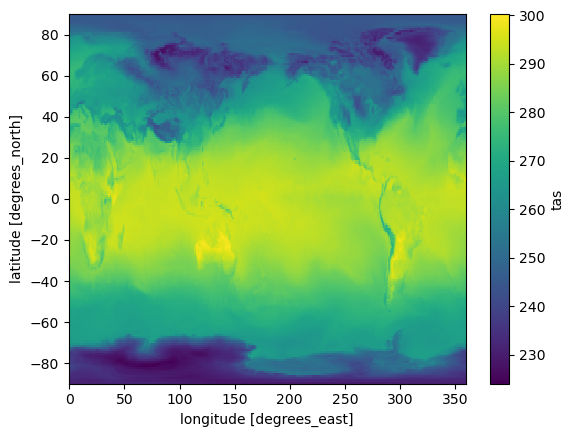

In [26]:
tasr.mean("time").plot()

## Example 3: Healpix data (ICON)

We can also read healpix data. Healpix implements the `zoom` parameter. `zoom=9` (default) is 12.5 Km, every lower number halves resolution. 

In [16]:
reader = Reader(model="ICON", exp="hpx", zoom=9)
data = reader.retrieve()

KeyError: 'Zarr object is missing the attribute `_ARRAY_DIMENSIONS` and the NCZarr metadata, which are required for xarray to determine variable dimensions.'

In [ ]:
data

<xarray.Dataset>
Dimensions:             (time: 8640, pix: 3145728, level: 90)
Coordinates:
  * level               (level) float64 nan 1.0 2.0 3.0 ... 86.0 87.0 88.0 89.0
  * time                (time) datetime64[ns] 2020-07-23T00:30:00 ... 2021-01-19
Dimensions without coordinates: pix
Data variables:
    10m_wind_speed      (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cli                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    clivi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    cllvi               (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    clw                 (time, level, pix) float32 dask.array<chunksize=(1, 10, 262144), meta=np.ndarray>
    sea_level_pressure  (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>
    tas                 (time, pix) float32 dask.array<chunksize=(1, 1048576), meta=np.ndarray>

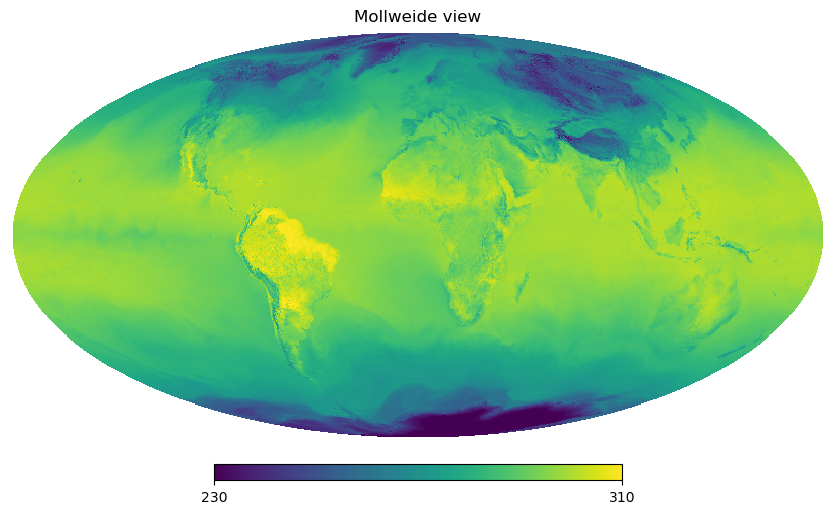

In [ ]:
import healpy
healpy.visufunc.mollview(
    data.tas.sel(time="2020-11-02T19:00:00").values,
    nest=True, flip="geo", min=230, max=310)

## Example 4: FESOM data (interpolated)

### 1. Hi-res interpolated FESOM data - no further interpolation

In [18]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS")
data = reader.retrieve()

The fixer has renamed `temp` to  `to` and converted `degC` to `K`.

In [19]:
data

<xarray.Dataset>
Dimensions:    (depth: 21, lat: 2700, lon: 5400, time: 2776)
Coordinates:
  * depth      (depth) float64 2.5 7.5 12.5 17.5 22.5 ... 87.5 92.5 97.5 105.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2020-01-20T02:56:00 ... 2020-12-31T23:56:00
    latitude   (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    longitude  (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
Data variables:
    salt       (time, depth, lat, lon) float32 dask.array<chunksize=(1, 6, 900, 1800), meta=np.ndarray>
    to         (time, depth, lat, lon) float32 dask.array<chunksize=(1, 6, 900, 1800), meta=np.ndarray>
Attributes: (12/21)
    FESOM_ClimateDataPath:               /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_MeshPath:                      /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_evp_rheol_steps:               120
    FESOM_force_rotation:                -1
    FESOM_git_SHA:                       469e74b1
    FESOM_include_fleapyear:             -1
    ...                                  ...
    FESOM_which_ALE:                     zstar
    box:                                 -180, 180, -90, 90
    data:                                /work/bm1235/a270046/cycle2-sync/tco...
    influence:                           80000
    interp:                              nn
    meshpath:                            /work/ab0995/a270088/meshes/NG5

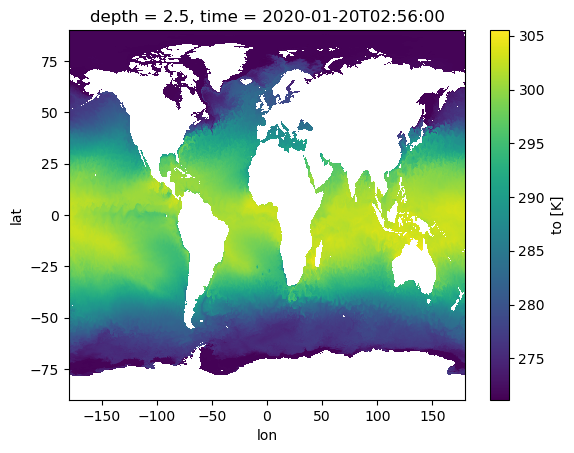

In [4]:
data.to.isel(time=0).isel(depth=0).plot()

### 2. Hi-res interpolated FESOM data - with further interpolation

These are masked 3d data. For now (working on it), we can only interpolate one level at the time. So a level has to be specified and the retrieve method will only provide data from that level. An error is raised if level is not specified in this case.

In [22]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="interpolated_global_TS", regrid="r100", level=20)

In [23]:
data = reader.retrieve()

In [7]:
data

<xarray.Dataset>
Dimensions:    (lat: 2700, lon: 5400, time: 2776)
Coordinates:
    depth      float64 105.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * time       (time) datetime64[ns] 2020-01-20T02:56:00 ... 2020-12-31T23:56:00
    latitude   (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
    longitude  (time, lat, lon) float64 dask.array<chunksize=(1, 2700, 5400), meta=np.ndarray>
Data variables:
    salt       (time, lat, lon) float32 dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
    to         (time, lat, lon) float32 dask.array<chunksize=(1, 900, 1800), meta=np.ndarray>
Attributes: (12/21)
    FESOM_ClimateDataPath:               /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_MeshPath:                      /ec/res4/scratch/natr/RAPS/20/inputs...
    FESOM_evp_rheol_steps:               120
    FESOM_force_rotation:                -1
    FESOM_git_SHA:                       469e74b1
    FESOM_include_fleapyear:             -1
    ...                                  ...
    FESOM_which_ALE:                     zstar
    box:                                 -180, 180, -90, 90
    data:                                /work/bm1235/a270046/cycle2-sync/tco...
    influence:                           80000
    interp:                              nn
    meshpath:                            /work/ab0995/a270088/meshes/NG5

Notice: due to how the construction of the weights file is performed, for now regridding works correctly only for the top layer, if masks (like for an ocean) are needed.

By default these data have not been interpolated yet:

In [9]:
t = data.to.isel(time=0)
t

<xarray.DataArray 'to' (lat: 2700, lon: 5400)>
dask.array<getitem, shape=(2700, 5400), dtype=float32, chunksize=(900, 1800), chunktype=numpy.ndarray>
Coordinates:
    depth      float64 105.0
  * lat        (lat) float64 -90.0 -89.93 -89.87 -89.8 ... 89.8 89.87 89.93 90.0
  * lon        (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
    time       datetime64[ns] 2020-01-20T02:56:00
    latitude   (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>
    longitude  (lat, lon) float64 dask.array<chunksize=(2700, 5400), meta=np.ndarray>
Attributes:
    units:         K
    target_units:  K
    factor:        1
    offset:        273.15
    src_units:     degC
    units_fixed:   1

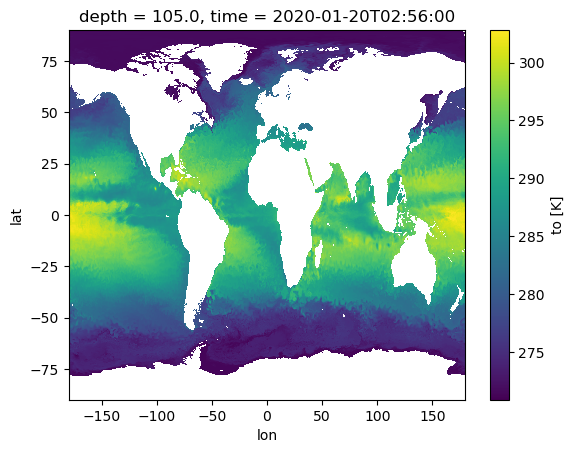

In [12]:
t.plot()

Now we actually regrid them

In [10]:
tr = reader.regrid(t)

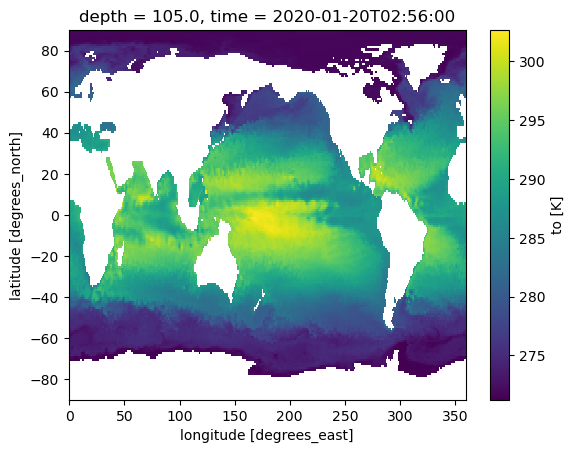

In [11]:
tr.plot()

### 3. Original FESOM data - further interpolation

In [37]:
reader = Reader(model="FESOM", exp="tco2559-ng5", source="original_2d", regrid="r020")

Weights file not found: /work/bb1153/b382075/nextgems/weights/weights_FESOM_tco2559-ng5_original_2d_ycon_r020_l2d.nc
Attempting to generate it ...
Source grid:  /work/bm1235/a270046/cycle2-sync/tcogrids/4km/tcogrids/tco2559_grid.nc
Success!


In [38]:
data = reader.retrieve()

In [35]:
sst0=data.sst.isel(time=0)

In [36]:
sst0.to_netcdf("/home/b/b382075/work/nextgems/grids/sst.nc")

In [40]:
data.MLD1[0:2,:]

<xarray.DataArray 'MLD1' (time: 2, nod2: 7402886)>
dask.array<getitem, shape=(2, 7402886), dtype=float32, chunksize=(1, 7402886), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-20T00:56:00 2020-01-20T01:56:00
Dimensions without coordinates: nod2
Attributes:
    description:  Mixed Layer Depth
    long_name:    Mixed Layer Depth
    units:        m

In [41]:
mld = reader.regrid(data.MLD1[0:2,:])

FileNotFoundError: [Errno 2] No such file or directory: b'/tmp/tmp279d01il'

## MSWEP precipitation data

Notice: this MSWEP part is still experimental and may not work/be efficient when you test it.

In [42]:
reader = Reader(model="MSWEP", exp="past", source="monthly")

(the "monthlyz" source is an experimental zarr version mapped with kerchunk)

In [43]:
data = reader.retrieve()

precipitation: corrected multiplying by density of water 1000 kg m-3
precipitation: incommensurate units converting mm month-1 to kg m-2 s-1 --> dimensionless


The fixer (on by default) has renamed the MSWEP `precipitation` variable to `pr` and converted it to SI units (it was monthly cumulated precipitation).

In [44]:
data.pr

<xarray.DataArray 'pr' (time: 502, lat: 1800, lon: 3600)>
dask.array<mul, shape=(502, 1800, 3600), dtype=float32, chunksize=(1, 1800, 3600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -179.9 -179.8 -179.8 -179.6 ... 179.8 179.9 179.9
  * lat      (lat) float32 89.95 89.85 89.75 89.65 ... -89.75 -89.85 -89.95
  * time     (time) int32 28885 28913 28944 28974 ... 44042 44073 44103 44134
Attributes:
    units:         kg m-2 s-1
    target_units:  kg m-2 s-1
    factor:        3.802570537683474e-07
    offset:        0
    src_units:     mm month-1
    units_fixed:   1

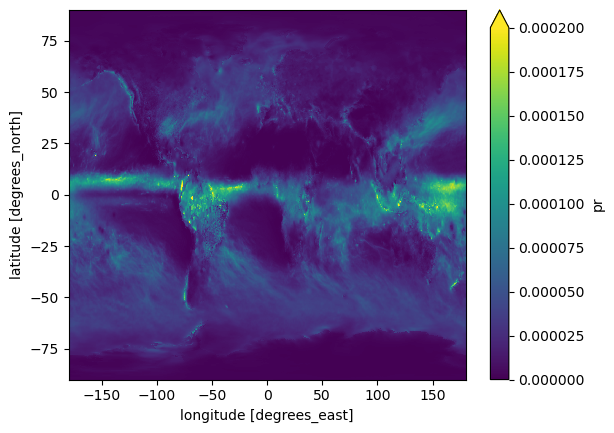

In [46]:
data.pr.isel(time=[0,1,2,3]).mean("time").plot(vmin=0, vmax=0.0002)